<a href="https://colab.research.google.com/github/ryderwishart/biblical-machine-learning/blob/main/syntax_knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os

if 'biblical-machine-learning' not in [path for path in os.listdir()]:
    !git clone https://github.com/ryderwishart/biblical-machine-learning.git

Cloning into 'biblical-machine-learning'...
remote: Enumerating objects: 1370, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1370 (delta 45), reused 69 (delta 38), pack-reused 1284
Receiving objects: 100% (1370/1370), 71.44 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Updating files: 100% (1332/1332), done.


In [45]:
from pathlib import Path
from collections import defaultdict

file_paths = []
for path in Path("biblical-machine-learning/data/dependencies").glob("*.csv"):
    file_paths.append(os.path.abspath(path))

# Define a function to read the contents of a file
def read_lines(file_path):
    with open(file_path, "r") as f:
        lines = []
        for line in f:
            fields = line.strip().split('|')
            line_dict = defaultdict(str)
            id, form, head_id, func = fields[0:4]
            line_dict['morphgnt_id'] = id
            line_dict['morphgnt_head_id'] = head_id
            line_dict['function'] = func
            for field in fields[5:]:
                key, value = field.split('=')
                line_dict[key] = value
            lines.append(line_dict)
        return lines

lines = []
for file_path in file_paths:
    for line in read_lines(file_path):
        lines.append(line)

import pandas as pd

frame = pd.DataFrame(lines)

subset_df = frame[frame['ref'].str.contains('2JN 1:1')]

In [46]:
subset_df.head()

,morphgnt_id,morphgnt_head_id,function,ref,Cat,Start,End,StrongNumber,UnicodeLemma,Gender,...,LexDomain,LN,Mood,Tense,Voice,SubjRef,Frame,Ref,Person,Degree
61579,63001001001,84001001002,det,"""2JN 1:1!1""","""det""","""0""","""0""","""3588""","""ὁ""","""Masculine""",...,"""092004""","""92.24""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61580,63001001002,84001001002,CL,"""2JN 1:1!2""","""adj""","""1""","""1""","""4245""","""πρεσβύτερος""","""Masculine""",...,"""053009""","""53.77""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Comparative"""
61581,63001001003,84001001004,adjp,"""2JN 1:1!3""","""adj""","""2""","""2""","""1588""","""ἐκλεκτός""","""Feminine""",...,"""030006""","""30.93""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61582,63001001004,84001001002,IO,"""2JN 1:1!4""","""noun""","""3""","""3""","""2959""","""κυρία""","""Feminine""",...,"""087003""","""87.54""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61583,63001001005,84001001004,conj,"""2JN 1:1!5""","""conj""","""4""","""4""","""2532""","""καί""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
import networkx as nx

selected_frame = subset_df # frame for full NT

# Initialize an empty directed graph
G = nx.DiGraph()

# Iterate through the dataset rows and add nodes and edges
for index, row in selected_frame.iterrows():
    morphgnt_id = row['morphgnt_id']
    morphgnt_head_id = row['morphgnt_head_id']
    function = row['function']
    normalized_form = row['NormalizedForm']
    pos = row['Cat']

    # Add nodes for morphgnt_id and morphgnt_head_id if they don't exist
    if not G.has_node(morphgnt_id):
        G.add_node(morphgnt_id, type='morphgnt', normalized_form=normalized_form, label=normalized_form)
    if not G.has_node(morphgnt_head_id):
        G.add_node(morphgnt_head_id, type='morphgnt', label=normalized_form)

    # Check if the node corresponds to a verb, and if so, add an edge instead of a node
    if pos == 'verb':
        # Add an edge between morphgnt_id and morphgnt_head_id with the 'function' as an attribute
        G.add_edge(morphgnt_head_id, morphgnt_id, label=normalized_form, function=function)
    else:
        # Add an edge between morphgnt_id and morphgnt_head_id with the 'function' as an attribute
        G.add_edge(morphgnt_id, morphgnt_head_id, label=function, function=function)



In [12]:
# source_node = 'source_morphgnt_id'
# target_node = 'target_morphgnt_id'
# shortest_path = nx.shortest_path(G, source=source_node, target=target_node)
# print(shortest_path)


In [48]:
print('Nodes: ', G.number_of_nodes())
print('Edges: ', G.number_of_edges())

Nodes:  126
Edges:  91


In [49]:
G.nodes['63001001001']

{'type': 'morphgnt', 'normalized_form': '"Ὁ"', 'label': '"Ὁ"'}

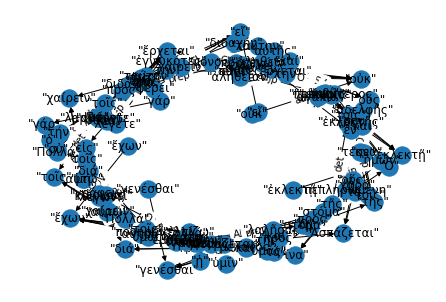

In [50]:
# import matplotlib.pyplot as plt

# pos = nx.spring_layout(G)
# nx.draw(G, pos, with_labels=True)
# edge_labels = nx.get_edge_attributes(G, 'function')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# plt.show()

import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(G)

# Create a dictionary that maps node IDs to their labels
labels = {node_id: G.nodes[node_id]['label'] for node_id in G.nodes()}

# Draw the graph with node labels
nx.draw(G, pos, with_labels=True, labels=labels)

# Draw edge labels as before
edge_labels = nx.get_edge_attributes(G, 'function')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


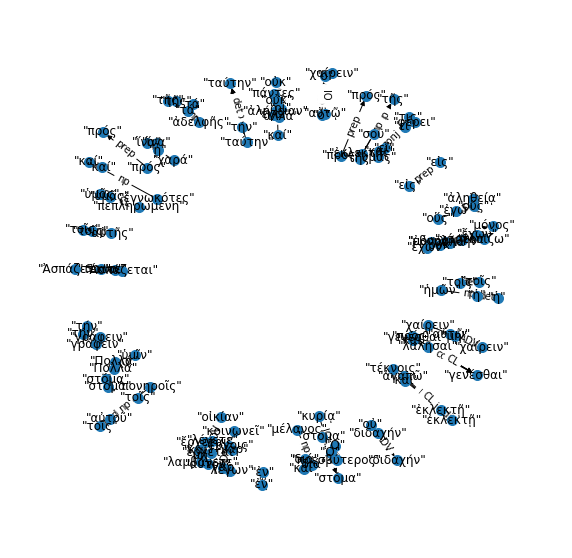

In [51]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)

# Create a dictionary that maps node IDs to their labels
labels = {node_id: G.nodes[node_id]['label'] for node_id in G.nodes()}

# Set the figure size to 10x10 inches
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the graph with node labels
nx.draw(G, pos, with_labels=True, labels=labels, ax=ax, node_size=100)

# Draw edge labels as before
edge_labels = nx.get_edge_attributes(G, 'function')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Avoid node overlap
plt.margins(0.1, 0.1)

plt.show()


In [44]:
import lxml
output_file = "dep-graph.graphml"
nx.write_graphml(G, output_file)
